## Описание проекта

**Цель:** 1)  спрогнозировать вероятность оттока на уровне следующего месяца для каждого клиента;
2) сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
3) проанализировать основные признаки, наиболее сильно влияющие на отток;
4) сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
а) выделить целевые группы клиентов;
б) предложить меры по снижению оттока;
в) определить другие особенности взаимодействия с клиентами.

«Культурист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
1. Данные клиента за предыдущий до проверки факта оттока месяц:
1) 'gender' — пол;
2) 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
3) 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
4) Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
5) 'Phone' — наличие контактного телефона;
6) 'Age' — возраст;
7) 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
1) 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
2) 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
3) 'Group_visits' — факт посещения групповых занятий;
4) 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
5) 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
6) 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
3. 'Churn' — факт оттока в текущем месяце.

## Загрузка и предобработка данных

In [1]:
#импортируем для работы библиотеки, которые могут понадобится в процессе
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy import stats as st
import math as mth
import datetime as dt
from pandas.plotting import register_matplotlib_converters
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import itertools

import warnings
warnings.simplefilter('ignore')

# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
# выгрузим датасет и сохраним его в переменную
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

print(f'Размер датасета: ', gym_churn.shape)

Размер датасета:  (4000, 14)


In [3]:
# изучим информацию о нем и посмотрим на первые 5 строк
display(gym_churn.info(), gym_churn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
#изменим регистр в наименовании столбцов для удобства работы с ними
gym_churn.columns = map(str.lower, gym_churn.columns)
gym_churn.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
#проверка на пропуски и дубликаты
print('Количество дубликатов: ', gym_churn.duplicated().sum())
print('Количество пропусков: ', gym_churn.isna().sum())

Количество дубликатов:  0
Количество пропусков:  gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64


In [6]:
# посмотрим на распределения значений
display(gym_churn.describe(percentiles=[1/2, 0.95]).T)

,count,mean,std,min,50%,95%,max
gender,4000.0,0.510250,0.499957,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,12.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,29.000000,34.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,136.220159,323.440876,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,12.000000,12.000000


In [7]:
 # посмотрим соотношение между активными и ушедшими клиентами
gym_churn.groupby('churn')['gender'].count()

churn
0    2939
1    1061
Name: gender, dtype: int64

Дейстующих клиентов почти в три раза больше, чем клиентов оттока. Однако такое кол-во уходящих клиентов говорит о том, что действительно проблема стоит остро, и фитнес центр потенциально может нести большие финансовые потери (как денег, которые уже в обороте, за счет приостановки действующих абонементов, так и потенциальной прибыли за счет непродленный абонементов). 

In [8]:
# посмотрим, как отличаются средние между активными и ушедшими клиентами
display(gym_churn.groupby('churn').mean().T)

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Вывод:** в датасете содержится 4000 строк и 14 столбцов, информация о столбцах была получена ранее от заказчика. Пропусков  нет, категориальных значений нет - судя по всему, заказчик самостоятельно перевел категориальные признаки в числовые со значениями 1 и 0. Нам остается лишь правильно интерпретировать эти значения. Чаще всего 0 это "Нет", а 1 это "Да". Относительно пола клиента фитнес-центра будем далее смотреть на соотношение долей клиентов, т.к. из личного опыта и в целом так сложилось исторически, что большая доля клиентов фитнес-центров - это женщины (исключениями могут быть специализированные центры с уклоном в сторону "грубых" видов спорта по типо тяжелой атлетики, бокса и т.д., но это не наш случай). Также важно отметить, что целевая переменная не имеет временной структуры, хотя нам и предстоит прогнозирование оттока на следующий месяц. Однако в данном случае мы будем работать с лайфтаймом и количеством месяцев действия абонемента, а не с непосредственно с датами и временем. На данном этапе были скорректированы лишь наименования столбцов для простоты дальнейшей работы с нимим. Дейстующих клиентов почти в три раза больше, чем клиентов оттока.

## EDA. Формулировка гипотез

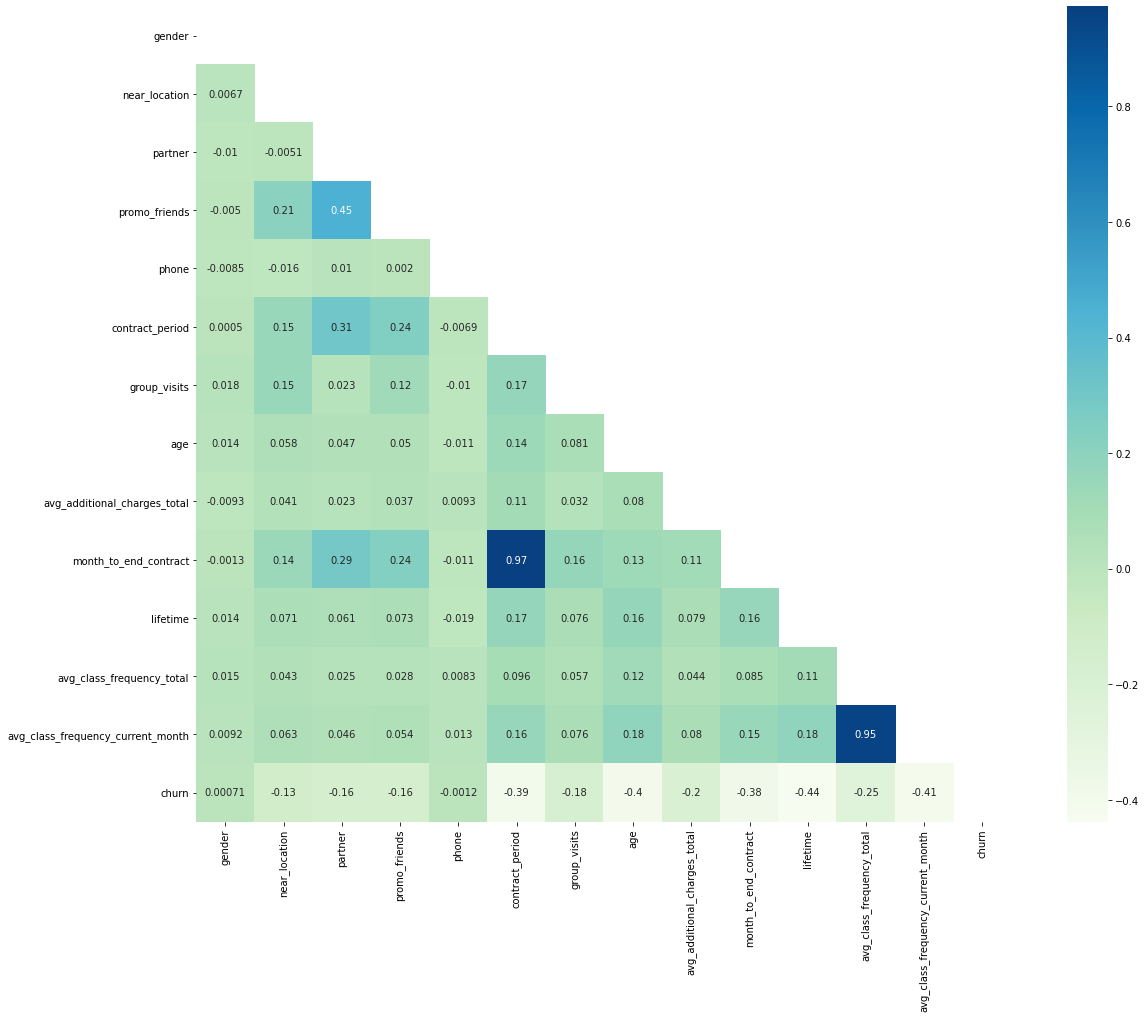

In [9]:
# построим и отрисуем матрицу корреляций
cm = gym_churn.corr() #вычисляем матрицу корреляций 

# для того, чтобы заать формат треугольной тепловой карты
gym_churn_new = gym_churn.copy()
matrix = np.triu(gym_churn_new.corr())

plt.figure(figsize=(20,15))

# нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot = True, square = True, cmap = 'GnBu', mask = matrix)
plt.show()

**Вывод:** наблюдаем сильную корреляцию между month_to_end_contract и contract_period, а также между avg_class_frequency_current_month и avg_class_frequency_total. Скорее всего связь в первой паре для абонементов на 1 месяц это одно и то же число. Во второй паре - люди в целом ходят относительно стабильно в течение действия абонемента. Сильной прямой корреляции между оттоком нет ни с какими признаками не могу выделить.

In [10]:
# выделим бинарные признаки
bin_ = []
nonbin = []
for col in gym_churn.columns.values:
    if gym_churn[col].max() == 1:
        bin_.append(col)
    else:
        nonbin.append(col)
print(bin_)
print(nonbin)

['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']
['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']


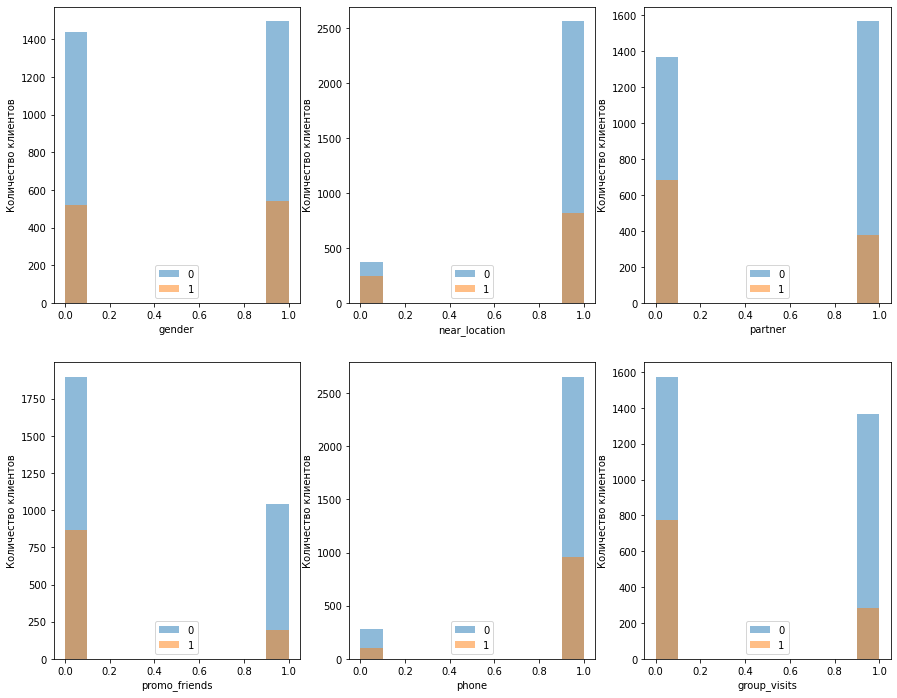

In [11]:
# визуализируем отличия для бинарных признаков
plt.figure(figsize=(15, 12))
for i in range(len(bin_)-1):   
    ax = plt.subplot(2, 3, i+1)
    ax.hist(gym_churn.query('churn == 0')[bin_[i]], alpha=0.5, label='0')
    ax.hist(gym_churn.query('churn == 1')[bin_[i]], alpha=0.5, label='1')
    plt.xlabel(bin_[i])
    plt.ylabel('Количество клиентов')
    plt.legend(loc='lower center')
plt.show()

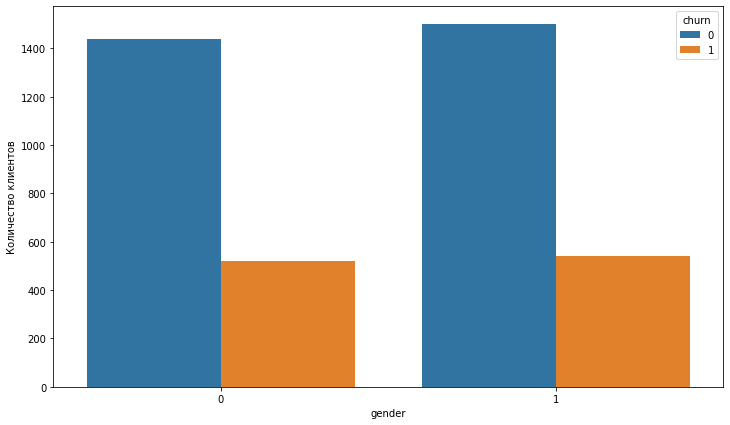

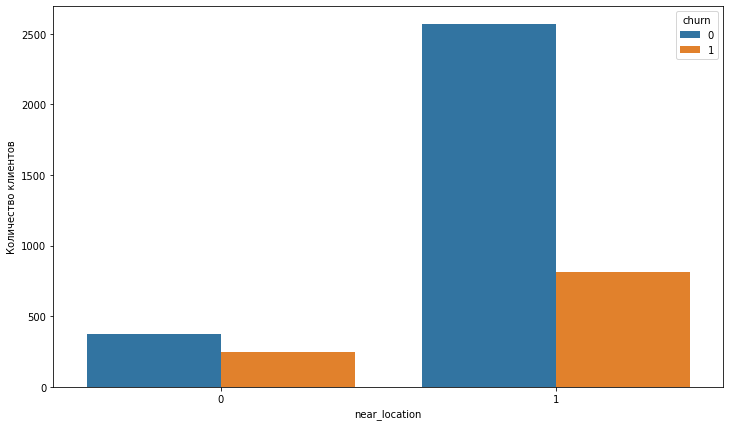

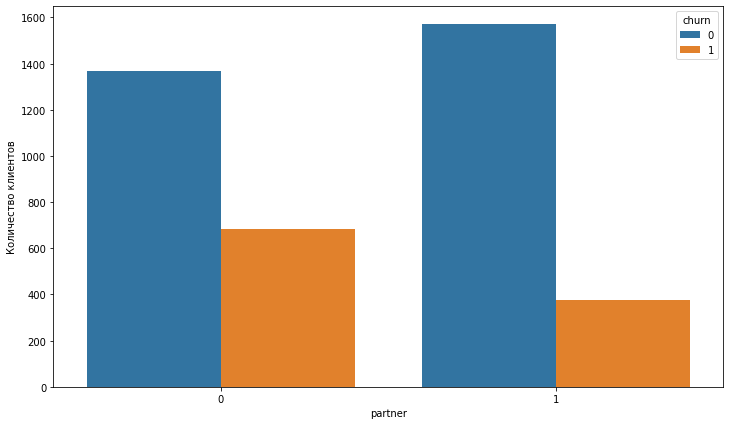

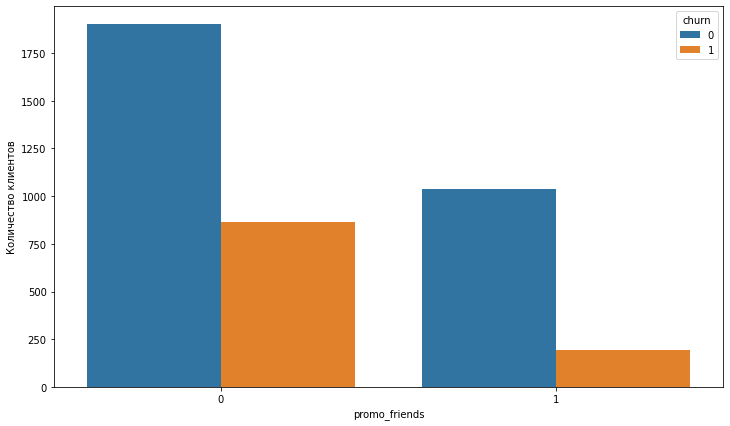

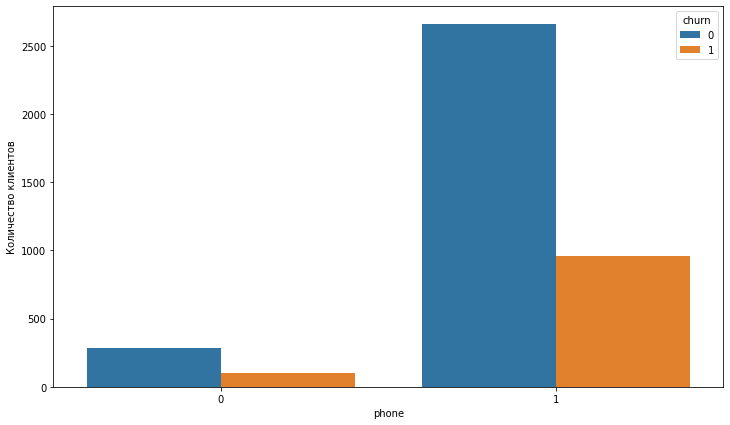

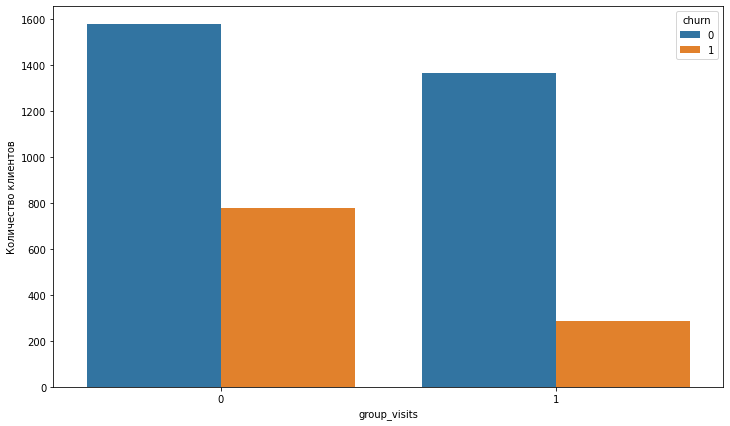

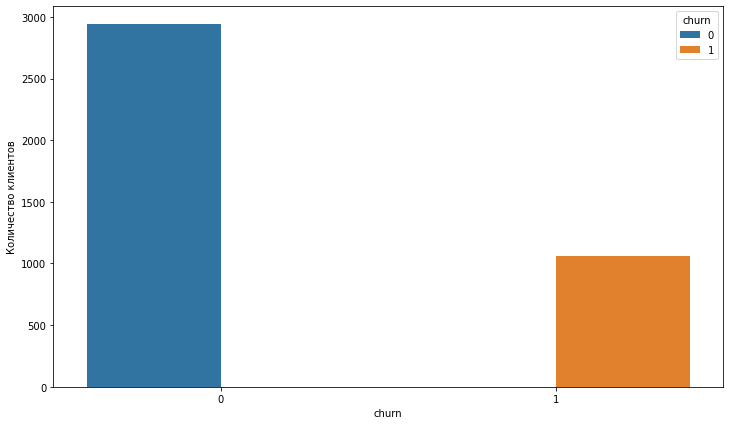

In [12]:
for col in bin_:
    plt.figure(figsize = (12, 7))
    sns.countplot(x = col, data = gym_churn, hue = 'churn')
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
plt.show()

Наблюдаем превалирование оттока среди клиентов, которые живут далеко от фитнес-центра, и тех, чей контактный телефон не указан в базе фитнес-центра. С расстоянием все понятно - чем дальше нужно ехать/идти, тем больше люди ленятнся. С телефоном же, вероятно, дело в том, что а) людей не могут оповестить и каких-то мероприятиях/новых тренажерах и программах, и поэтому постепенно интерес теряется; б) сотрудники не могут дозвониться до клеинтов, чтобы оповестить об окончании абонемента и предложить продлить его, т.е. теряется возможность не только сделать дополнительную продажу, но и в целом держать связь с клиентом после его ухода (даже в отрыве от исследования могу порекомендовать сделать сбор контактных номеров обязательным); в) из личного опыта могу сказать, что когда долго не ходишь в зал, сотрудники могут позвонить и уточнить причину, в результате чего люди чувствуют стыд и начинают ходить в зал снова, так что это тоже немаловажный момент.
Также стоит отметить и то, что при записи в фитнес-центр "через друга" наблюдается отток менее обычного, хотя в других случаях он примерно равен притоку. Считаю, что тут также играет роль стыд/совесть, упомянутые ранее - чувство вины перед другим человеком заставляет людей дольше ходить в спортзал.

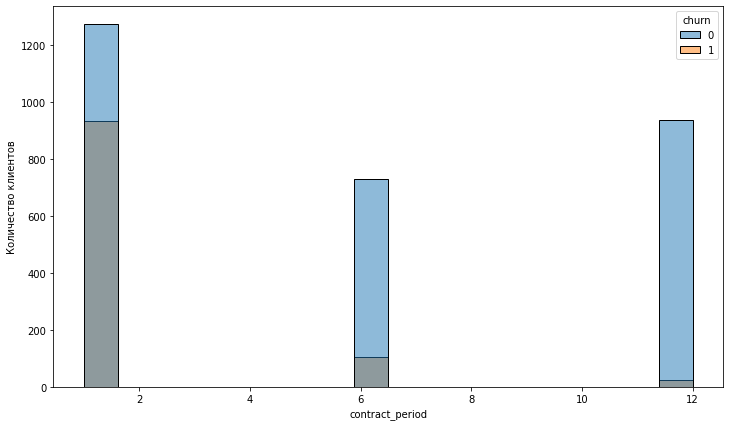

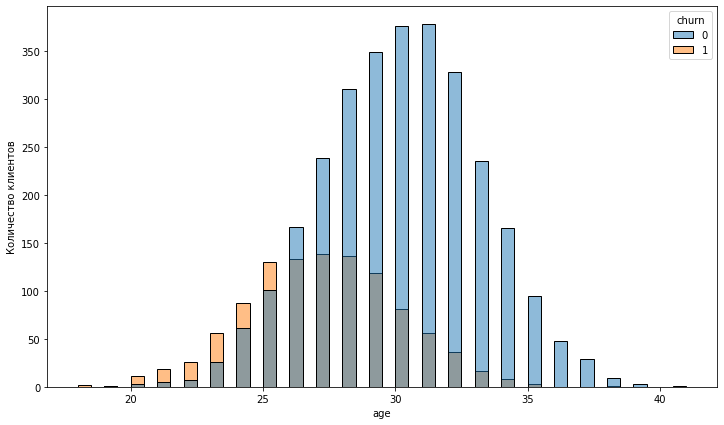

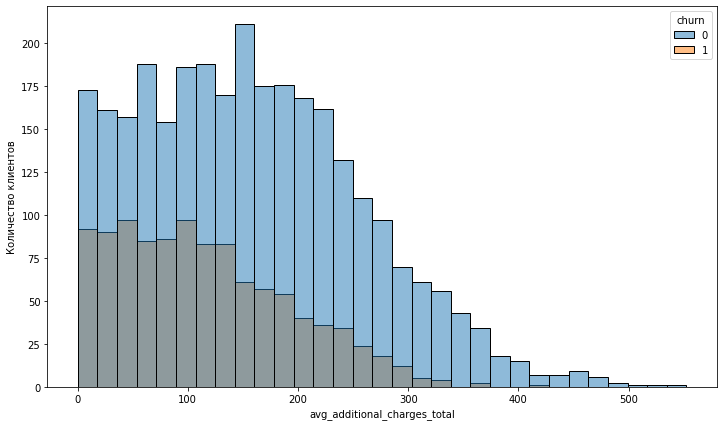

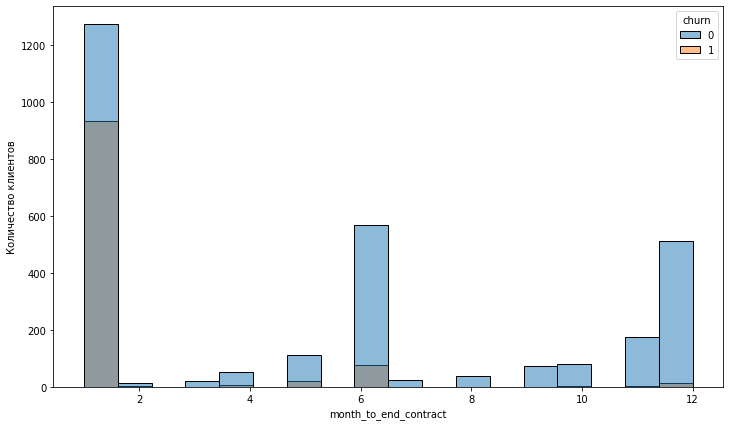

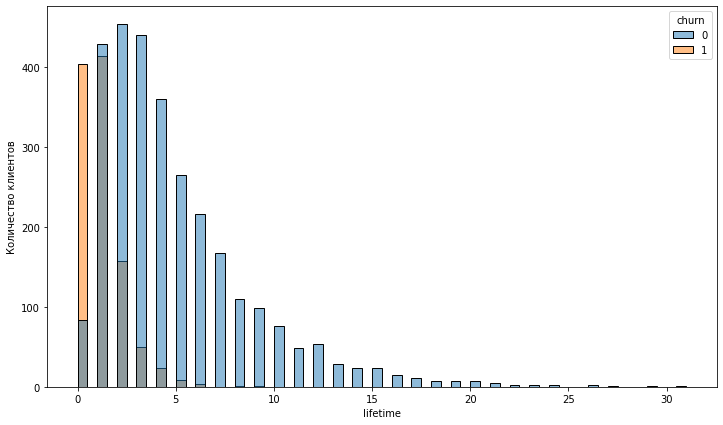

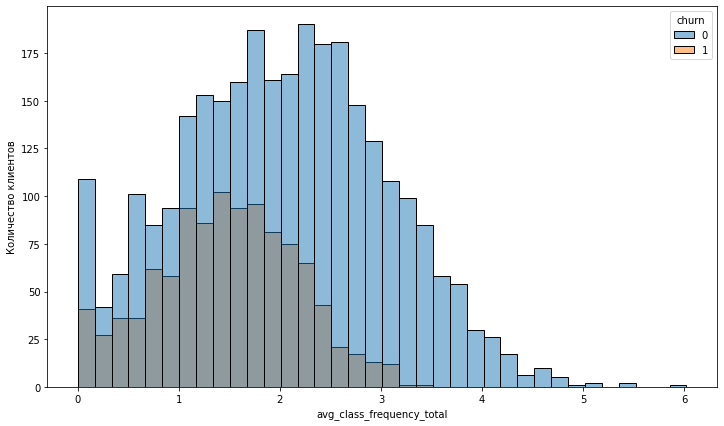

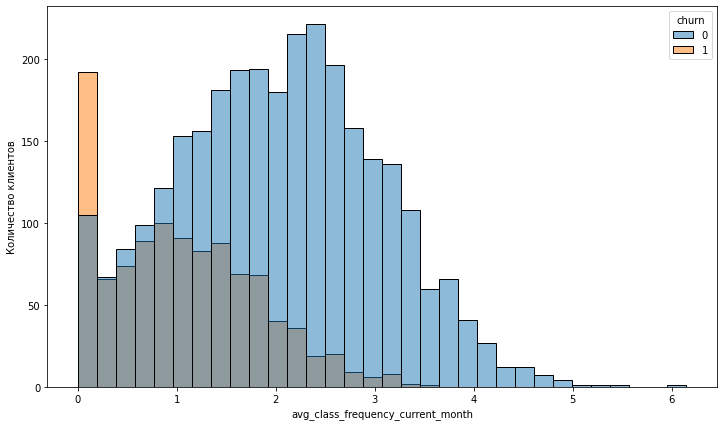

In [13]:
# визуализируем отличия для небинарных признаков
for col in nonbin:
    plt.figure(figsize = (12, 7))
    sns.histplot(x = col, data = gym_churn, hue = 'churn')
    plt.xlabel(col)
    plt.ylabel('Количество клиентов')
plt.show()
    

**Вывод:** чаще в отток уходят клиенты, которые не ходили в зал  меполедний месяц и те, кто приобрел абонемент на 1 месяц. Также в отток попадают те, кто пришел не более 3 месяцев назад, и те, у кого до окончания абонемента остался также один месяц. Чаще всего клиенты оттока - это люди 28-32 лет. Могу предположить, что такое поведение клиентов связано с тем, что это люди с работой и "забитым" графиком, вероятно, даже с детьми.

## Модель прогнозирования оттока клиентов

In [14]:
#разделим наши данные на признаки матри X и целевую переменную y
X = gym_churn.drop('churn', axis=1)
y = gym_churn['churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()

#обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st =  scaler.fit_transform(X_train)

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

In [15]:
#kjubcnbxtcrfz htuhtccbz
def print_metrics(data_true, data_predicted):
    print('Доля правильных ответов:', accuracy_score(data_true, data_predicted))
    print('Точность:', precision_score(data_true, data_predicted))
    print('Полнота:', recall_score(data_true, data_predicted))
    print('F1-мера:', f1_score(data_true, data_predicted))
    print('ROC-AUC', roc_auc_score(data_true, data_predicted))

In [16]:
# задаем алгоритм для модели
model = LogisticRegression(penalty='l1', random_state=0, solver='liblinear')

# обучаем модель
model.fit(X_train_st, y_train)

y_pred = model.predict(X_test_st) #прогноз класса после обучения такой модели

# метрики для логистической регрессии
print_metrics(y_test, y_pred)

Доля правильных ответов: 0.935
Точность: 0.8921568627450981
Полнота: 0.8584905660377359
F1-мера: 0.875
ROC-AUC 0.9105378000256706


**Вывод:** наблюдаем более 80% верных прогнов по каждой метрике, хороший результат.

In [17]:
# случайный лес
model = RandomForestClassifier(random_state = 0)

# обучаем модель
model.fit(X_train_st, y_train)

y_pred = model.predict(X_test_st) #прогноз класса после обучения такой модели

# метрики для логистической регрессии
print_metrics(y_test, y_pred)

Доля правильных ответов: 0.9225
Точность: 0.875
Полнота: 0.8254716981132075
F1-мера: 0.8495145631067961
ROC-AUC 0.8914773456552433


**Вывод:** также более 80% верных ответов, но предыдущая модель даёт результаты чуть лучше. Так что возьмём её на вооружение.

## Шаг 4. Кластеризация клиентов

In [ ]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

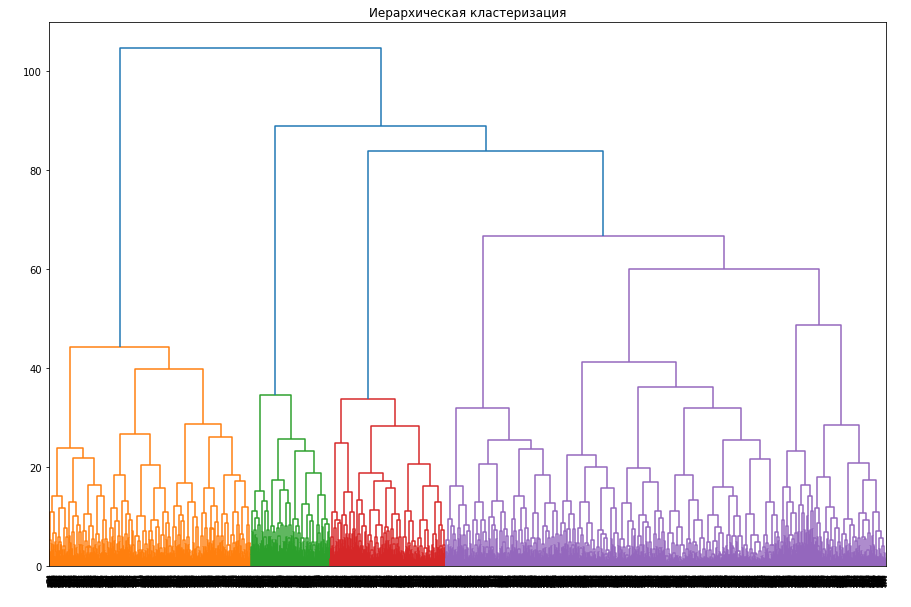

**Вывод:** оптимальное число кластеров - четрые, судя по цветовой гамме на визуализации.

In [ ]:
# K-Means
# количество кластеров было оговорено в задании
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster_km'] = labels

In [ ]:
# выводим статистику по средним значениям всех признаков по кластеру
display(gym_churn.groupby('cluster_km').mean().T)

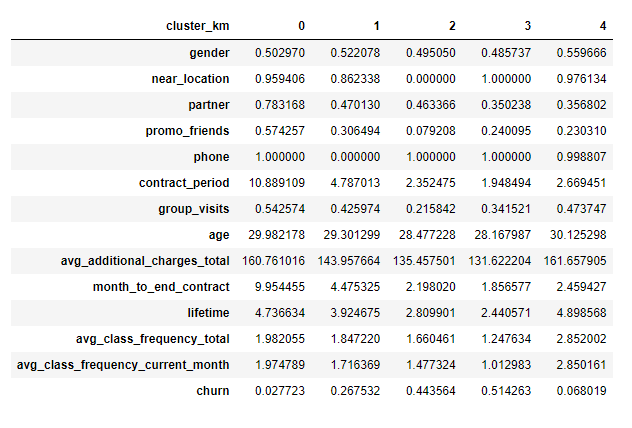

**Вывод:** в кластерах 0 и 4 клиенты, которые ходят на фитнес наиболее ответственно. В этих кластерах почти все клиенты живут недалеко от клуба и чаще остальных ходят на групповые занятия. Также их траты на дополнительные услуги больше, чем у остальных, и они же дольше являются клиентами и чаще тренируются - как за все всемя, так и в предыдущий месяц. В 1 кластере наибольшая доля сотрудников компаний-партнеров, больше всего приобретено годовых абонементов, которые открыты не так давно. В кластере 3 самая большая доля оттока при этом - эти клиенты и реже всех тренируются, и меньше всех тратят на дополнительные услуги, и абонементы чаще всего берут на 1 месяц.

In [ ]:
# построим графики распределения признаков в зависимости от кластера для выделяющихся трех кластеров - 0, 4 и 3
# при построении графиков для всех пяти кластеров они смешиваются в нечитаемую кашу
for col in gym_churn:
    plt.figure(figsize=(20, 7))
    for i in [0, 3, 4]:
        sns.distplot(gym_churn.query('cluster_km == @i')[col], bins = 50, label='cluster_km ' + str(i))
    plt.title(col)    
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

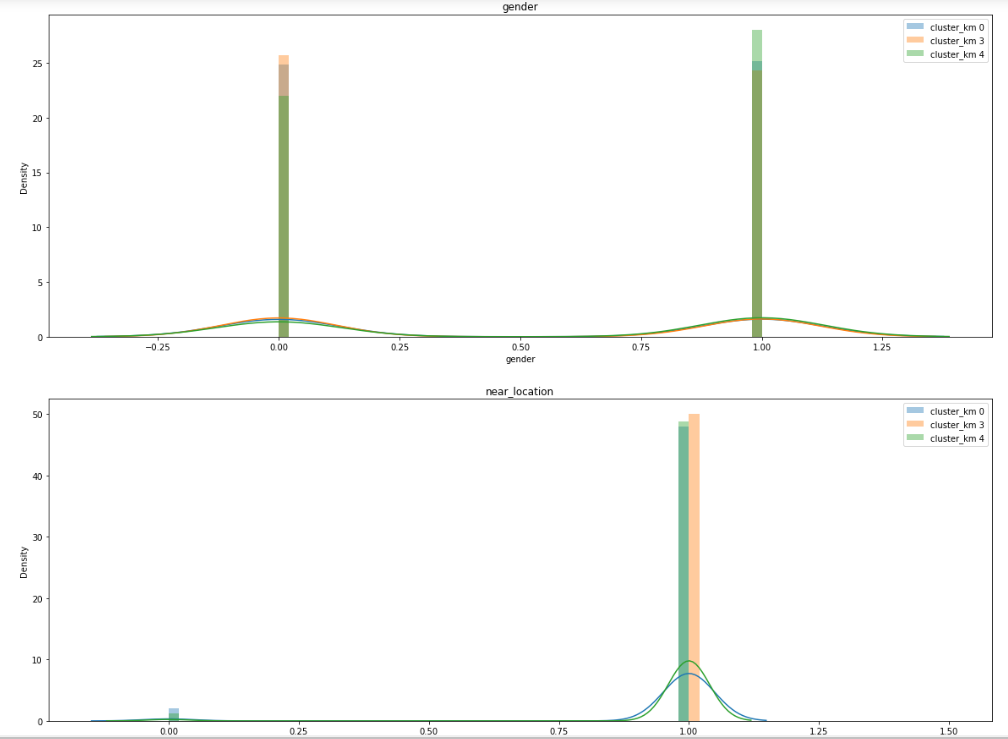

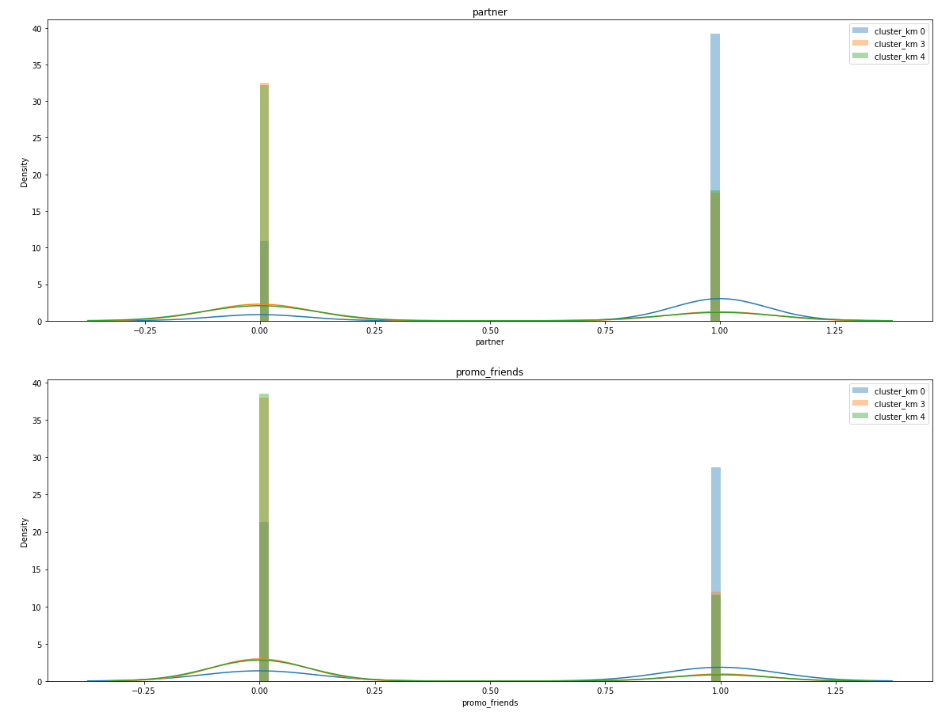

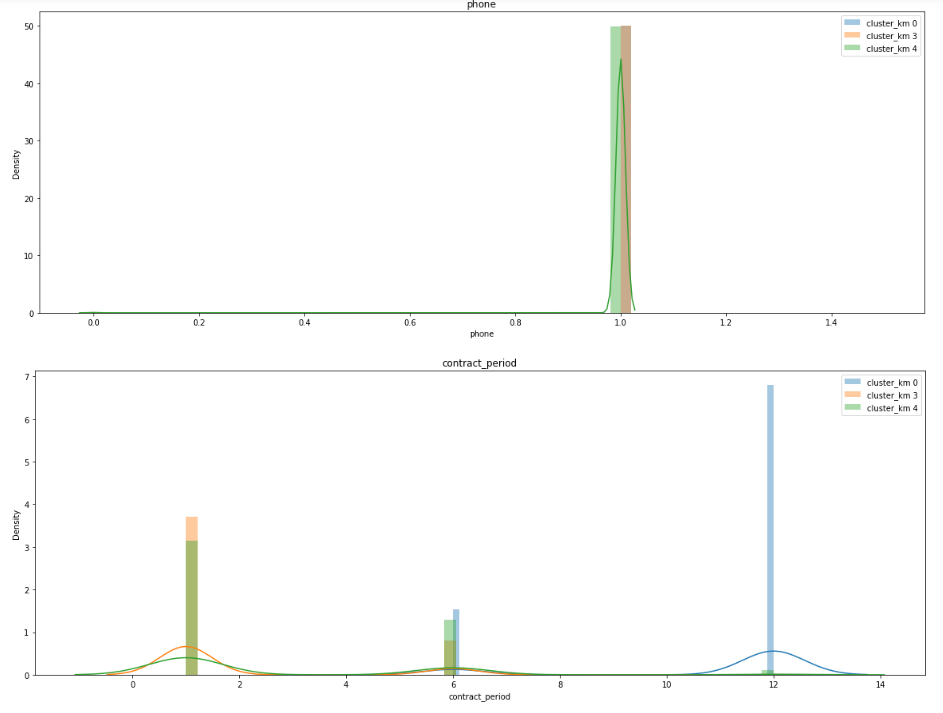

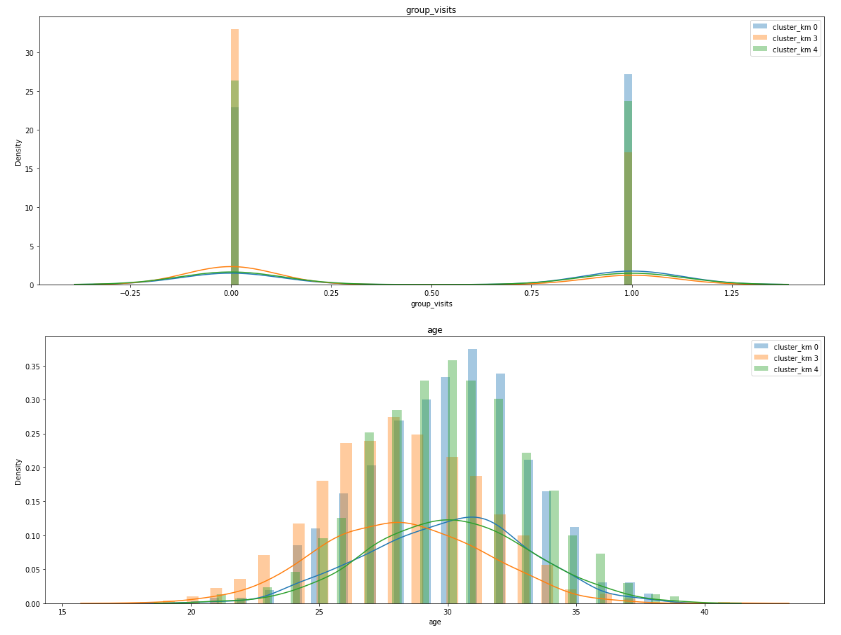

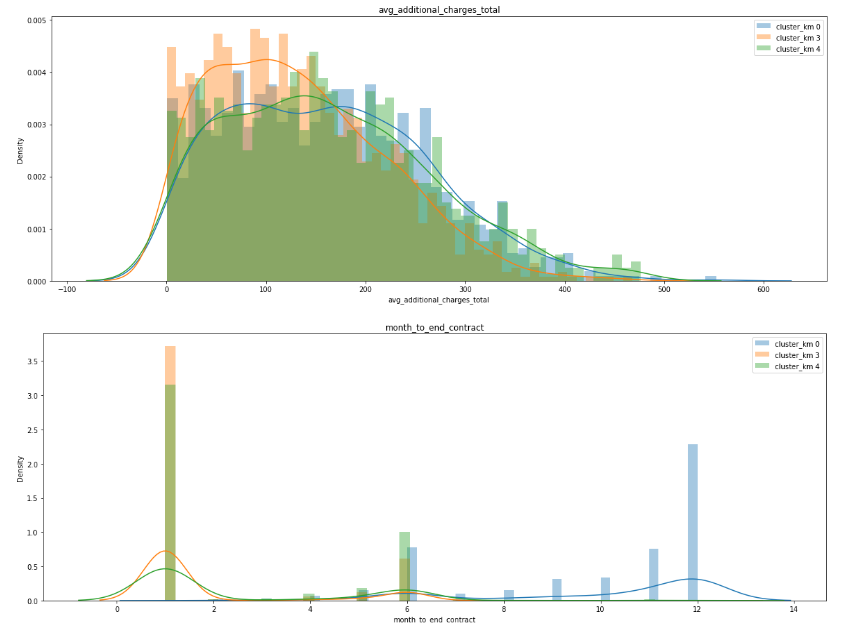

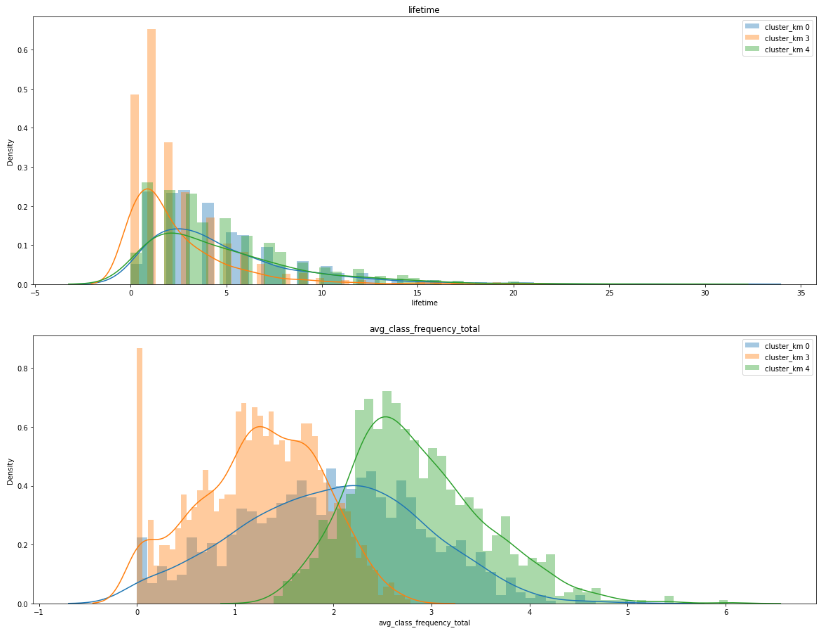

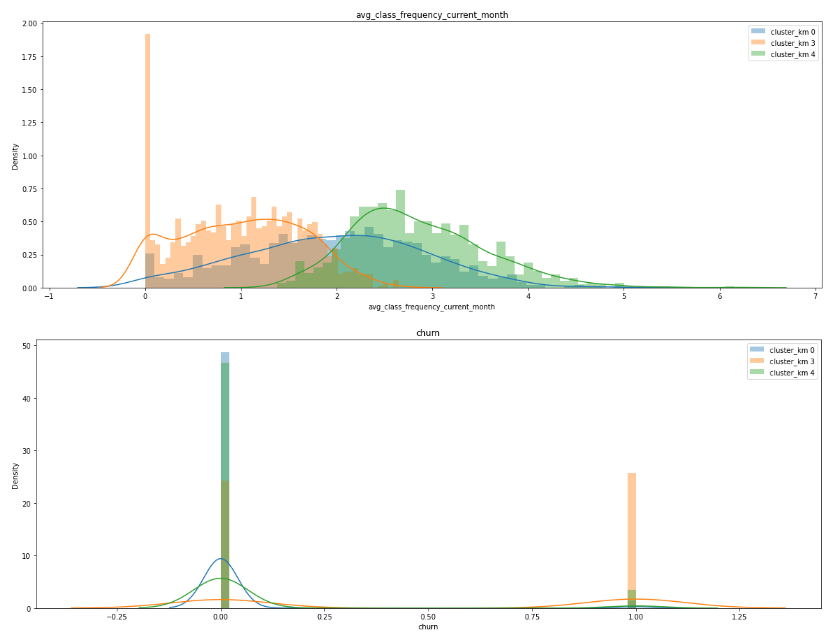

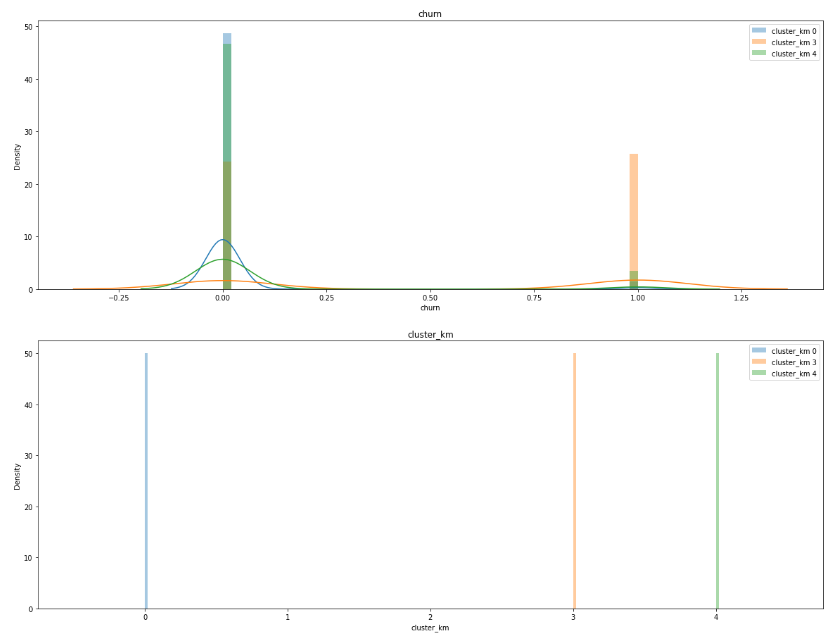

**Вывод:**
1) В кластере 1 наибольшее кол-во владельцев годовых абонементов, в 4 их мало, в 3 нет совсем.
2) В кластере 3 средний возраст немного ниже, чем в 1 и 4.
3) В кластере 3 меньше в среднем тратят на доп. услуги клуба.
4) В кластере 3 клиенты, которые пришли позднее, чем клиенты остальных кластеров.
5) В кластере 3 клиенты тренируются реже, чем в других кластерах (как на протяжении всего времени, так и в последний месяц). Также среди них наибольшее кол-во клиентов, которые вообще не посещали клуб в последний месяц. 
6) В кластере 4 таких нет клиентов, которые бы не послещали фитнес в последний месяц.

## Общий вывод

В датасете содержится 4000 строк и 14 столбцов, пропусков  нет, категориальных значений нет - судя по всему, заказчик самостоятельно перевел категориальные признаки в числовые со значениями 1 и 0. Целевая переменная не имеет временной структуры. На данном этапе были скорректированы наименования столбцов для простоты дальнейшей работы с нимим. Выяснили, что дейстующих клиентов почти в три раза больше, чем клиентов оттока.

Тепловая карта по матрице корреляций показала сильную корреляцию между month_to_end_contract и contract_period, а также между avg_class_frequency_current_month и avg_class_frequency_total. Скорее всего связь в первой паре для абонементов на 1 месяц это одно и то же число. Во второй паре - люди в целом ходят относительно стабильно в течение действия абонемента. Сильной прямой корреляции между оттоком нет ни с какими признаками.

Наблюдаем превалирование оттока среди клиентов, которые живут далеко от фитнес-центра, и тех, чей контактный телефон не указан в базе фитнес-центра. С расстоянием все понятно - чем дальше нужно ехать/идти, тем больше люди ленятнся. С телефоном же, вероятно, дело в том, что а) людей не могут оповестить и каких-то мероприятиях/новых тренажерах и программах, и поэтому постепенно интерес теряется; б) сотрудники не могут дозвониться до клеинтов, чтобы оповестить об окончании абонемента и предложить продлить его, т.е. теряется возможность не только сделать дополнительную продажу, но и в целом держать связь с клиентом после его ухода (даже в отрыве от исследования могу порекомендовать сделать сбор контактных номеров обязательным); в) из личного опыта могу сказать, что когда долго не ходишь в зал, сотрудники могут позвонить и уточнить причину, в результате чего люди чувствуют стыд и начинают ходить в зал снова, так что это тоже немаловажный момент.
Также стоит отметить и то, что при записи в фитнес-центр "через друга" наблюдается отток менее обычного, хотя в других случаях он примерно равен притоку. Считаю, что тут также играет роль стыд/совесть, упомянутые ранее - чувство вины перед другим человеком заставляет людей дольше ходить в спортзал.

Чаще в отток уходят клиенты, которые не ходили в зал  меполедний месяц и те, кто приобрел абонемент на 1 месяц. Также в отток попадают те, кто пришел не более 3 месяцев назад, и те, у кого до окончания абонемента остался также один месяц. Чаще всего клиенты оттока - это люди 28-32 лет. Могу предположить, что такое поведение клиентов связано с тем, что это люди с работой и "забитым" графиком, вероятно, даже с детьми.

Для прогнозирования оттока на следующий месяц выбрали логистическую регрессию, она показала наиболее высокие результаты (более 80%).

Кластеризация показала, что:

1) В кластере 1 наибольшее кол-во владельцев годовых абонементов, в 4 их мало, в 3 нет совсем.
2) В кластере 3 средний возраст немного ниже, чем в 1 и 4.
3) В кластере 3 меньше в среднем тратят на доп. услуги клуба.
4) В кластере 3 клиенты, которые пришли позднее, чем клиенты остальных кластеров.
5) В кластере 3 клиенты тренируются реже, чем в других кластерах (как на протяжении всего времени, так и в последний месяц). Также среди них наибольшее кол-во клиентов, которые вообще не посещали клуб в последний месяц. 
6) В кластере 4 таких нет клиентов, которые бы не послещали фитнес в последний месяц.

Итого, признаки, наиболее сильно свазанные с оттоком:

1. Удаленность клуба от места жительства человека - те, кто живут близко, бросают занятия реже.
2. Посещение групповых занятий - те, кто чаще ходят на них, бросают режео.
3. Общая частота посещений - чем чаще человек ходит в клуб, тем выше вероятность, что он не бросит занятия.
4. Покупка дополнительных услуг - чем больше выручка от сопутствующих услуг, тем вероятнее, что человек продолжит заниматься (этот параметр кажется более связан с тем, что реже бросают клиенты с бОльшим стажем - и они просто успели потратить больше). 
5. Длительность абонемента - купившие годовой доступ бросают реже.
6. Возраст - реже бросают клиенты постарше (от 35 лет).

При этом пол клиента, рекомендация от друга, наличие контактного номера телефона не показывают заметного влияния на отток. 

Рекомендации для сокращения оттока:
1. Бонусы/подарки за кол-во посещений - 3 посещения в неделю + бесплатный поход на платное групповое занятие, 10 посещений в месяц + браслет со встроенным пропуском в подарок, 2 посещения в неделю + скидка на посещение хамама и т.д.
2. Напоминалки о групповых занятиях в вид пушей (+ сбор телефонов для того, чтобы напоминалки получали большее кол-во клиентов).
3. Чаще проводить акции по более длительным абонементам, чтобы люди чувствовали выгоду не только в длительности, но и в цене на расстоянии нескольких месяцев-года.
4. Провести исследование на предмет того, как себ ведет конкретно молодёж в 
придложение новым клиентам более выгодных длительных абонементов (полгода, год)внедрение абонементов, нацеленных только на посетителей групповых занятий - танцы или йога могут показаться более интересными, чем силовые упражнения, но закрепят привычку посещать клубдобавить к акции "Приведи друга" обратную сторону - бонус за приведенного друга, посетившего клуб, например, не менее 4 разпо завершении месячного абонемента напоминать новым клиентам о выгодных длительных абонементах